In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from data import *
from util import *
from imageio import imsave

In [3]:
x_train, x_test = load_CIFAR10()
x_train = x_train[0:100]
x_val = x_test[-100:]
x_test = x_test[0:1000]
check_range(x_train)
x_test.shape

Files already downloaded and verified
Files already downloaded and verified
0.0 0.9999000430107117


torch.Size([1000, 1, 32, 32])

In [4]:
# size of magnitude: 
# (32, 32) vs. (64, 64)
# --> non-oversampled vs. oversampled
s = (64,64) 

# size of images
si = (32,32)

In [5]:
def GS_reference(y, u, imsize=(32, 32), s=(64, 64), steps=100):
    x = torch.zeros(len(y), 1, *imsize)
    
    for i in range(steps):
        # Fourier domain constraints
        intermed = torch.fft.ifft2(phase(x+u, s=s)*y)[:,:, :32, :32].real
        
        # Image domain constraints
        x = intermed - u
        x[x<0] = 0
    return x


def HIO_reference(y, u, imsize=(32, 32), s=(64, 64), beta=0.89, steps=100):
    x = torch.zeros(len(y), 1, *imsize)
    
    for i in range(steps):
        # Fourier domain constraints
        intermed = torch.fft.ifft2(phase(x+u, s=s)*y)[:,:, :32, :32].real
        
        # Image domain constraints
        x_new = intermed - u
        x_new[x_new<0] = x[x_new<0]-beta*x_new[x_new<0]
        
        x = x_new
    return x

In [6]:
#u = np.load('references/u_mnist.npy')

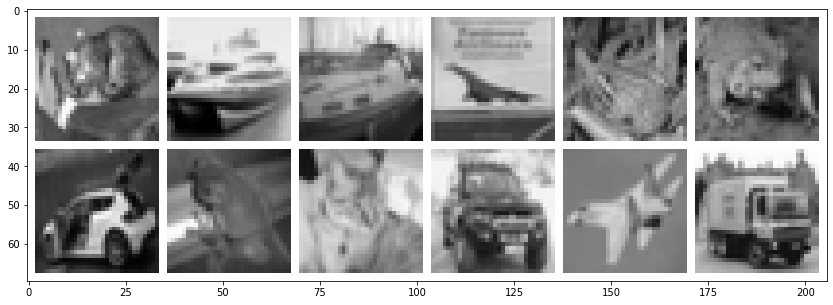

In [7]:
plt.figure(figsize=(19,5))
to_plot = torchvision.utils.make_grid(x_test[:12], nrow=6, pad_value=1).permute(1,2,0)
plt.imshow(to_plot)

In [8]:
train_generator = torch.utils.data.DataLoader(x_train, batch_size=10, shuffle=True)
u = torch.rand(32, 32, requires_grad=True)
opt = torch.optim.Adam([u], lr=0.01)
losses = []
for epoch in range(10):
    print(epoch)
    for i, batch in enumerate(train_generator):
        y = magnitude(batch + u, s=s, norm='backward')
        x_rec = GS_reference(y, u, imsize=(32, 32), s=s, steps=15)
        loss = torch.mean(torch.square(x_rec-batch))
        losses.append(loss.item())
        loss.backward()
        opt.step()
    
        u.data[u<0] = 0.
        u.data[u>1] = 1.

0


/home/touel100/.local/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


1
2
3
4
5
6
7
8
9


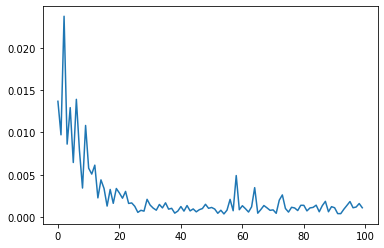

In [9]:
plt.plot(losses)

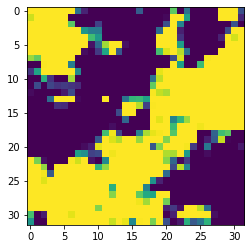

In [10]:
plt.imshow(u.detach())

In [11]:
y = magnitude(x_test + u, s=s, norm='backward')
rec = GS_reference(y, u, imsize=(32, 32), s=s, steps=500).detach()
rec[rec>1] = 1
check_range(rec)

0.0 1.0


In [12]:
psnr_vals = [psnr(rec[i, None], x_test[i, None]).item() for i in range(len(rec))]
mse_vals = [mse(rec[i, None], x_test[i, None]).item() for i in range(len(rec))]
ssim_vals = [ssim(rec[i, None], x_test[i, None]).item() for i in range(len(rec))]
print('PSNR: %f +/- %f' % (np.mean(psnr_vals), np.std(psnr_vals)))
print('MSE: %f +/- %f' % (np.mean(mse_vals), np.std(mse_vals)))
print('SSIM: %f +/- %f' % (np.mean(ssim_vals), np.std(ssim_vals)))

PSNR: 90.659553 +/- 33.390266
MSE: 0.000171 +/- 0.001072
SSIM: 0.994708 +/- 0.025004


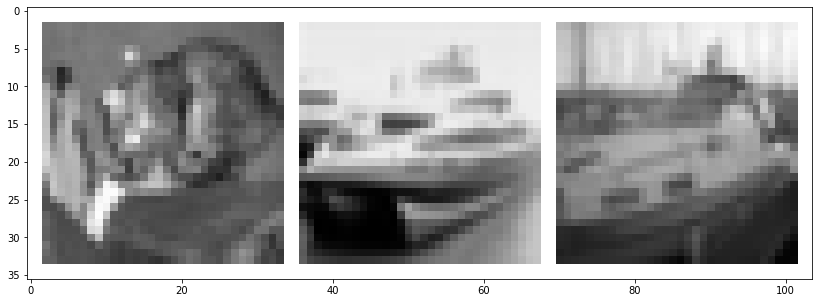

In [13]:
import imageio
plt.figure(figsize=(19,5))
to_plot = torchvision.utils.make_grid(x_test[:3], nrow=6, pad_value=1).permute(1,2,0)
plt.imshow(to_plot)

In [14]:
from skimage.registration import phase_cross_correlation
def cross_correlation(moving, fixed):
    
    if moving.shape[-1] == 3:
        moving_gray = rgb2gray(moving)
        fixed_gray = rgb2gray(fixed)
    elif moving.shape[-1] == 1:
        moving_gray = moving[..., 0]
        fixed_gray = fixed[..., 0]
    else:
        print("Image channel Error!")
    
    shift, error, diffphase = phase_cross_correlation(moving_gray, fixed_gray)
    out = np.roll(moving, -np.array(shift).astype(np.int), axis=(0, 1))
    return out, error

def register_croco(predicted_images, true_images, torch=True):
    pred_reg = np.empty(predicted_images.shape, dtype=predicted_images.dtype)

    for i in range(len(true_images)):
        if torch:
            true_image = true_images[i].transpose(1, 2, 0)
            predicted_image = predicted_images[i].transpose(1, 2, 0)
        else:
            true_image = true_images[i]
            predicted_image = predicted_images[i]

        shift_predict, shift_error = cross_correlation(predicted_image, true_image)
        rotshift_predict, rotshift_error = cross_correlation(np.rot90(predicted_image, k=2, axes=(0, 1)), true_image)
        
        if torch:
            pred_reg[i] = shift_predict.transpose(2, 0, 1) if shift_error <= rotshift_error else rotshift_predict.transpose(2, 0, 1)
        else:
            pred_reg[i] = shift_predict if shift_error <= rotshift_error else rotshift_predict
        
    return pred_reg

x_rec_reg = register_croco(np.array(rec), x_test.numpy(),)

mse_vals = [mse(torch.tensor(x_rec_reg[i, None]), x_test[i, None]).item() for i in range(len(x_rec_reg))]
print('MSE: %f +/- %f' % (np.mean(mse_vals), np.std(mse_vals)))

MSE: 0.000171 +/- 0.001072


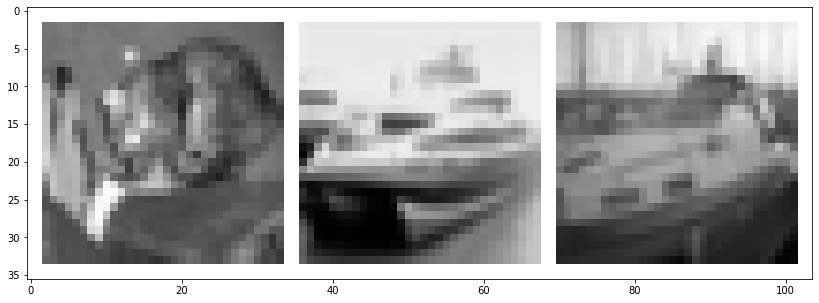

In [15]:
plt.figure(figsize=(19,5))
to_plot = torchvision.utils.make_grid(torch.tensor(x_rec_reg[:3]), nrow=6, pad_value=1).permute(1,2,0)
plt.imshow(to_plot)